# Deep Flow Prediction
Based on:
<br>
 https://arxiv.org/abs/1810.08217 by N. Thuerey, K. Weissenov, H. Mehrotra, N. Mainali, L. Prantl, X. Hu (TUM)
<br>
https://github.com/thunil/Deep-Flow-Prediction

## Aim:
Predicting approximate solutions to Reynolds-Averaged Navier-Stokes equation with best possible accuracy by application of a deep neural network

In [1]:
# First the model is initialized and pre-trained weights are loaded

import matplotlib.pyplot as plt
import os, sys, random, math
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from dataset import TurbDataset
from DfpNet import TurbNetG, weights_init
import utils


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
expo = 7 # parameter necessary for determining the number of channels after the first convolution layer
modelFn = '../data/model_mata10_exp70.dms' # path to model weights
netG = TurbNetG(channelExponent=expo)
netG.load_state_dict(torch.load(modelFn, map_location=device))
netG.to(device)

TurbNetG(
  (layer1): Sequential(
    (layer1_conv): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (layer2): Sequential(
    (layer2_leakyrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (layer2_conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (layer2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2x): Sequential(
    (layer2x_leakyrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (layer2x_conv): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (layer2x_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (layer3_leakyrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (layer3_conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (layer3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer4): Sequential(
    (l

![title](../resources/overview.jpg)

# Summary of approach:
### Input:
3-channel image corresponding to the freestream conditions (i.e. the distant velocity field which can be assumed to be uneffected by the airfoil) and the shape of the airfoil as mask (1 inside and 0 outside of the airfoil)
### Output:
The predicted velocity vector field (2-channels) around the airfoil as well as the scalar pressure field (1-channel)
### Model: 
The Model is based on a U-net architecture which is actually the standard architecture for segmentation problems. The prediction happens by a basically symmetric process of downsampling (==> increase of global information resp. feature extraction but loss of local information) followed by a corresponding upsampling where related layer outputs of the down- and upsampling steps are resp. concatenated for further processing (==> regaining local information/resolution using the global and local features at the same time) 
<br>
**Layer blocks for downsampling**:
Convolutional layers with stride 2 (needes for downsampling) and kernel size 4 followed by LeakyRelu activation
<br>
**Layer blocks for upampling:**
Simple Upsampling layer (factor 2) followed by Convolutions with stride 1 and kernel size 3 as well as Relu activation
<br>
In both cases batchnorm is used.
<br>
**Heursitic justification for the approach:**
<br>
PDEs are problems of finding global functions given local information about them (resp. information about the function's partial derivatives) and boundary conditions. Thus, the process of aggregating local information in several steps considering the airfoil shape and the freefield followed by a sequential creation of the solution (using both aggregated and local information) seems to be a reasonable approach.

In [2]:
# Here predictions for test data (unseen airfoils and different freestream conditions) are generated
# and the model performance is measured by absolute and relative L1 distance of the p,v_x and v_y channels

print_all_losses = False # True if for each sample of the test data the respective losses shall be printed

dataset = TurbDataset(None, mode=TurbDataset.TEST, dataDirTest="../data/test/")
testLoader = DataLoader(dataset, batch_size=1, shuffle=False)

targets = torch.FloatTensor(1, 3, 128, 128)
targets = Variable(targets)
targets = targets.to(device)
inputs = torch.FloatTensor(1, 3, 128, 128)
inputs = Variable(inputs)
inputs = inputs.to(device)

targets_dn = torch.FloatTensor(1, 3, 128, 128)
targets_dn = Variable(targets_dn)
targets_dn = targets_dn.to(device)
outputs_dn = torch.FloatTensor(1, 3, 128, 128)
outputs_dn = Variable(outputs_dn)
outputs_dn = outputs_dn.to(device)


avgLoss = 0.

criterionL1 = nn.L1Loss()
criterionL1.to(device)
L1val_accum = 0.0
L1val_dn_accum = 0.0
lossPer_p_accum = 0
lossPer_v_accum = 0
lossPer_accum = 0

netG.eval()

losses = {'rel_L1_p':[],'rel_L1_vx':[],'rel_L1_vy':[]}
preds = []
tars = []

count = 0
for i, data in enumerate(testLoader, 0):
    # loading of test samples
    count += 1
    inputs_cpu, targets_cpu = data
    targets_cpu, inputs_cpu = targets_cpu.float().to(device), inputs_cpu.float().to(device)
    inputs.data.resize_as_(inputs_cpu).copy_(inputs_cpu)
    targets.data.resize_as_(targets_cpu).copy_(targets_cpu)
    
    # model prediction
    outputs = netG(inputs)
    outputs_cpu = outputs.data.cpu().numpy()[0]
    targets_cpu = targets_cpu.cpu().numpy()[0]

    lossL1 = criterionL1(outputs, targets)
    L1val_accum += lossL1.item()

    # precentage loss by ratio of means which is same as the ratio of the sum
    lossPer_p = np.sum(np.abs(outputs_cpu[0] - targets_cpu[0])) / np.sum(np.abs(targets_cpu[0]))
    lossPer_v = (np.sum(np.abs(outputs_cpu[1] - targets_cpu[1])) + np.sum(
        np.abs(outputs_cpu[2] - targets_cpu[2]))) / (
                            np.sum(np.abs(targets_cpu[1])) + np.sum(np.abs(targets_cpu[2])))
    lossPer = np.sum(np.abs(outputs_cpu - targets_cpu)) / np.sum(np.abs(targets_cpu))
    lossPer_p_accum += lossPer_p.item()
    lossPer_v_accum += lossPer_v.item()
    lossPer_accum += lossPer.item()
    
    losses['rel_L1_p'] += [lossPer_p.item()]
    losses['rel_L1_vx'] += [((np.sum(np.abs(outputs_cpu[1] - targets_cpu[1])))/ np.sum(np.abs(targets_cpu[1]))).item()]
    losses['rel_L1_vy'] += [((np.sum(np.abs(outputs_cpu[2] - targets_cpu[1])))/ np.sum(np.abs(targets_cpu[2]))).item()]
    if print_all_losses:
        print("Test sample %d" % i)
        print("relative L_1 error for pressure p:", lossPer_p.item())
        print("relative L_1 error for v_x:", (np.sum(np.abs(outputs_cpu[1] - targets_cpu[1]))/np.abs(targets_cpu[1]).sum()).item())
        print("relative L_1 error for v_x:",  (np.sum(np.abs(outputs_cpu[2] - targets_cpu[2]))/np.abs(targets_cpu[2]).sum()).item())

    # Calculate the norm
    input_ndarray = inputs_cpu.cpu().numpy()[0]
    v_norm = (np.max(np.abs(input_ndarray[0, :, :])) ** 2 + np.max(np.abs(input_ndarray[1, :, :])) ** 2) ** 0.5

    outputs_denormalized = dataset.denormalize(outputs_cpu, v_norm)
    targets_denormalized = dataset.denormalize(targets_cpu, v_norm)

    # denormalized error (i.e. the error for the unscaled data)
    outputs_denormalized_comp = np.array([outputs_denormalized])
    outputs_denormalized_comp = torch.from_numpy(outputs_denormalized_comp)
    targets_denormalized_comp = np.array([targets_denormalized])
    targets_denormalized_comp = torch.from_numpy(targets_denormalized_comp)

    targets_denormalized_comp, outputs_denormalized_comp = targets_denormalized_comp.float().to(
        device), outputs_denormalized_comp.float().to(device)

    outputs_dn.data.resize_as_(outputs_denormalized_comp).copy_(outputs_denormalized_comp)
    targets_dn.data.resize_as_(targets_denormalized_comp).copy_(targets_denormalized_comp)

    lossL1_dn = criterionL1(outputs_dn, targets_dn)
    L1val_dn_accum += lossL1_dn.item()

 
L1val_accum /= count
lossPer_p_accum /= count
lossPer_v_accum /= count
lossPer_accum /= count
L1val_dn_accum /= count
print("Loss percentage (p, v, combined): %f %%    %f %%    %f %% " % (
lossPer_p_accum * 100, lossPer_v_accum * 100, lossPer_accum * 100))

print(f"Denormalized error: {L1val_dn_accum}")




loading data for testing
Number of data loaded: 90
Using fixed maxima [4.65, 2.04, 2.37]
Data stats, input  mean 0.190220, max  0.961052;   targets mean 0.289502 , max 1.000000 
Loss percentage (p, v, combined): 13.048336 %    1.917543 %    2.316710 % 
Denormalized error: 0.010286299720529414


In [6]:
def imageOut(_outputs, _targets,normalize=False):
    """Function takes output and target array and returns their corresponding images.

    Args:
        _outputs (np.array): prediction of model.
        _targets (np.array): array with ground truth information.
        normalize (bool): the array will be normalized to range [0,1] before being plotted if True 
    """
    outputs = np.copy(_outputs)
    targets = np.copy(_targets)

    s = outputs.shape[1]  # should be 128

    for i in range(3):
        outputs[i] = np.flipud(outputs[i].transpose())
        targets[i] = np.flipud(targets[i].transpose())
        min_value = min(np.min(outputs[i]), np.min(targets[i]))
        max_value = max(np.max(outputs[i]), np.max(targets[i]))

        if normalize:
            outputs[i] -= min_value
            targets[i] -= min_value
            max_value -= min_value
            outputs[i] /= max_value
            targets[i] /= max_value
        else:  # from -1,1 to 0,1
            outputs[i] -= -1.
            targets[i] -= -1.
            outputs[i] /= 2.
            targets[i] /= 2.
    
    for n,c in {'pressure':0,'v_x':1,'v_y':2}.items():
        if normalize and n!='pressure':
            print(f'Image of {n} prediction (left) vs. Image of {n} target (right) resp. normalized to [0,1]:') 
        else:
            print(f'Image of {n} prediction (left) vs. Image of {n} target (right):')   
        fig, axarr = plt.subplots(1,2,figsize=(10,10))
        axarr[0].imshow(outputs[c])
        im = axarr[1].imshow(targets[c])
        
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.345, 0.04, 0.31])
        fig.colorbar(im, cax=cbar_ax)
        
        plt.show()
        


Test sample 35
relative L_1 error for pressure p: 0.04420942813158035
relative L_1 error for v_x: 0.005182775591364469
relative L_1 error for v_x: 0.017422397110610815
--------------------------
direction of the freefield


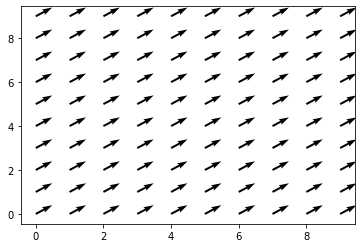

Image of pressure prediction (left) vs. Image of pressure target (right):


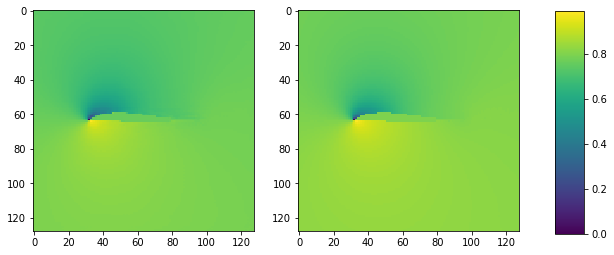

Image of v_x prediction (left) vs. Image of v_x target (right) resp. normalized to [0,1]:


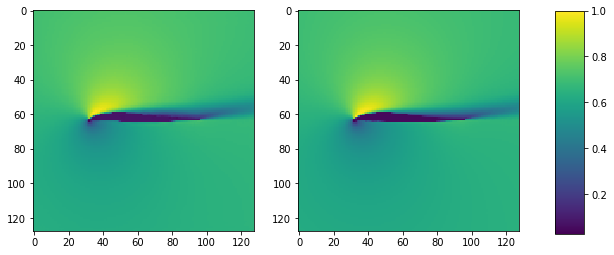

Image of v_y prediction (left) vs. Image of v_y target (right) resp. normalized to [0,1]:


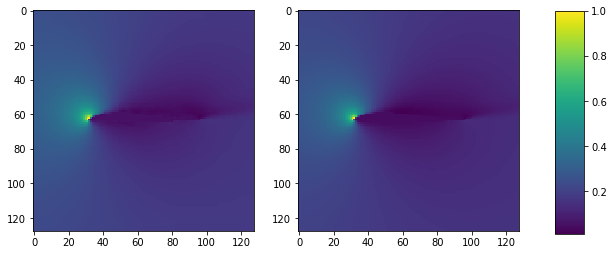

In [7]:
from matplotlib.pyplot import quiver
# here predictions and related targets can visualized
i = 35 # insert index of test sample which shall be analyzed 
i = i%len(dataset)
# 'relative' means in this context that the average L_1 error is divided by the average absolut value of the respective target
inputs_cpu, targets_cpu = dataset.__getitem__(i)
inputs_cpu =torch.from_numpy(inputs_cpu).float().to(device)

# model prediction
outputs = netG(inputs_cpu[None,...])
outputs_cpu = outputs.data.cpu().numpy()[0]
targets_cpu.shape,outputs_cpu.shape

print("Test sample %d" % i)
print("relative L_1 error for pressure p:", lossPer_p.item())
print("relative L_1 error for v_x:", (np.sum(np.abs(outputs_cpu[1] - targets_cpu[1]))/np.abs(targets_cpu[1]).sum()).item())
print("relative L_1 error for v_x:",  (np.sum(np.abs(outputs_cpu[2] - targets_cpu[2]))/np.abs(targets_cpu[2]).sum()).item())
print("--------------------------")
print('direction of the freefield')
quiver( inputs_cpu[0,0,0].detach()*np.ones((10,10)), inputs_cpu[1,0,0].detach()*np.ones((10,10)))
plt.show()
imageOut(outputs_cpu,targets_cpu,normalize=True)